# Spectrum and Cutout Plotting

This is a basic notebook that will plot spectra, redrock fits, and Legacy Survey cutouts in a nice way given the following:
- TARGETID
- DATE
- TILE

In [1]:
import os
from glob import glob

from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=18)
mpl.rc('axes', titlesize='small')

## Extract Object Redshifts

Specify the TARGETID, date, tile, and version of the spectroscopic reduction desired.

Note that `targetid` can be a list.

In [3]:
redux = 'daily/tiles/cumulative'
# tile = 20750
# date = 20210521
# targetid = 39632941629837556

tile = 21202
date = 20210514
targetid = 39632956406369645

In [4]:
folder = '{}/{}/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile, date)
coadds = sorted(glob('{}/coadd-*.fits'.format(folder)))

myspec = None

for i, coadd in enumerate(coadds):
    zbfile = coadd.replace('coadd', 'zbest')
    
    if os.path.exists(zbfile) and os.path.exists(coadd):
        spectra = read_spectra(coadd)
        sselect = np.in1d(spectra.fibermap['TARGETID'], targetid)
        if np.any(sselect):
            spectra = spectra[sselect]
            if not hasattr(spectra, 'scores_comments'):
                spectra.scores_comments = None
                
            # Select matching target IDs from the list and access the redshift fit.
            zbest = fits.open(zbfile)['ZBEST'].data
            zselect = np.in1d(zbest['TARGETID'], targetid)
            zbest = zbest[zselect]
            
                    # Append spectra to a larger list of spectra, stored in memory.
            # Note that an EXPID is required in the update step below, but the coadded spectra
            # have a FIRST_EXPID and a LAST_EXPID. So copy one of these as a hack.
            spectra.fibermap['EXPID'] = spectra.fibermap['LAST_EXPID']
            spectra.extra_catalog = zbest
            
            myspec = spectra
            break

INFO:spectra.py:253:read_spectra: iotime 0.624 sec to read coadd-0-21202-thru20210514.fits at 2021-06-16T12:25:56.696081
INFO:spectra.py:253:read_spectra: iotime 0.568 sec to read coadd-1-21202-thru20210514.fits at 2021-06-16T12:25:57.736474
INFO:spectra.py:253:read_spectra: iotime 0.528 sec to read coadd-2-21202-thru20210514.fits at 2021-06-16T12:25:58.729601
INFO:spectra.py:253:read_spectra: iotime 0.754 sec to read coadd-3-21202-thru20210514.fits at 2021-06-16T12:25:59.947272
INFO:spectra.py:253:read_spectra: iotime 0.616 sec to read coadd-4-21202-thru20210514.fits at 2021-06-16T12:26:01.046833
INFO:spectra.py:253:read_spectra: iotime 0.511 sec to read coadd-5-21202-thru20210514.fits at 2021-06-16T12:26:01.988406
INFO:spectra.py:253:read_spectra: iotime 0.476 sec to read coadd-6-21202-thru20210514.fits at 2021-06-16T12:26:02.854685
INFO:spectra.py:253:read_spectra: iotime 0.586 sec to read coadd-7-21202-thru20210514.fits at 2021-06-16T12:26:03.929288


In [5]:
myspec.num_spectra()

1

### Output Redrock Spectral Types

In [6]:
types_, counts_ = np.unique(myspec.extra_catalog['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(myspec.extra_catalog)))

GALAXY     :          1 (100.0%)


## Plot Spectra

### Grab Legacy Survey Cutouts

Some code to access legacy survey cutouts.

In [7]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

#### Spectrum Plot Options

Pull in a basic Gaussian smoothing filter and some code for plotting the same emission and absorption features used in Prospect.

In [8]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [9]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

352.42640310525894 0


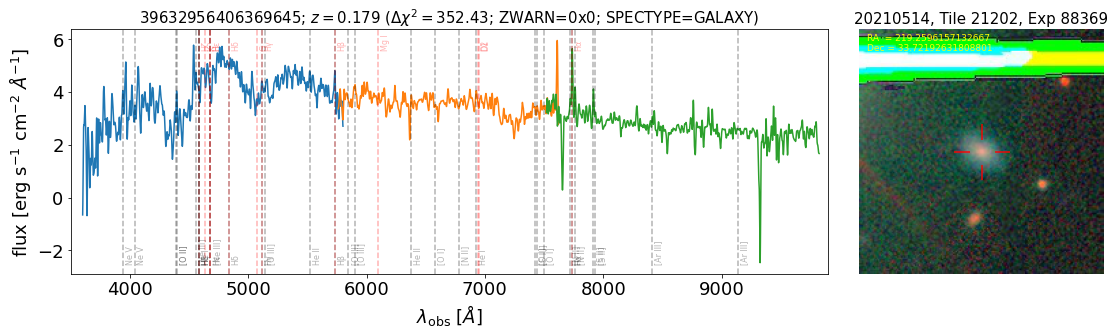

In [10]:
for i in range(myspec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99
    for band in 'brz':
        smoothed = gaussian_filter1d(myspec.flux[band][i], 5)
        fmin = np.minimum(fmin, np.min(smoothed))
        fmax = np.maximum(fmax, np.max(smoothed))
        ax.plot(myspec.wave[band], smoothed)
        
    zbest = myspec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)
    
    for eline in emi_lines:
        wl = eline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{obs}}$ [$\AA$]',
           xlim=(3500,9900),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(myspec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = myspec.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    ax.axis('off')
    
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']), dpi=100)
    
#     # Clean up
#     fig.clear()
#     plt.close(fig)

### Rest Frame Plot

352.42640310525894 0


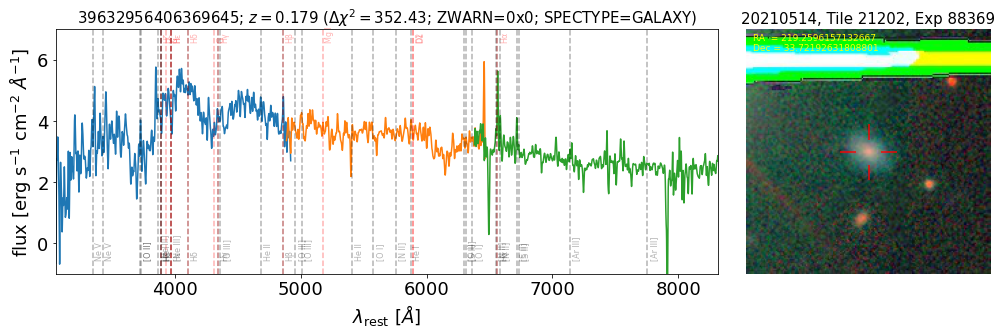

In [11]:
for i in range(myspec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(14.5,5), gridspec_kw={'width_ratios':[2.75,1.2]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    zbest = myspec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)
    
    fmin, fmax = 1e99, -1e99
    for band in 'brz':
        smoothed = gaussian_filter1d(myspec.flux[band][i], 5)
        fmin = np.minimum(fmin, np.min(smoothed))
        fmax = np.maximum(fmax, np.max(smoothed))
        ax.plot(myspec.wave[band]/(1 + z), smoothed)
    fmax = 7.
    
    for eline in emi_lines:
        wl = eline['lambda']
        if wl > 3600/(1+z) and wl < 9800/(1+z):
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, -0.5, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']
        if wl > 3600/(1+z) and wl < 9800/(1+z):
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(3600/(1 + z),9800/(1 + z)),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(-1, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(myspec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = myspec.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    ax.axis('off')
    
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']), dpi=120)
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.pdf'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    
#     # Clean up
#     fig.clear()
#     plt.close(fig)

## Compute and Subtract Redrock Model

Extract the redrock templates and use the best fit coefficients to plot and remove the best-fit model from the data.

In [12]:
import redrock.templates

templates = dict()
for f in redrock.templates.find_templates():
    t = redrock.templates.Template(f)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [13]:
zbest = myspec.extra_catalog[0]
z = zbest['Z']
sptype = zbest['SPECTYPE']
sbtype = zbest['SUBTYPE']
fulltype = (sptype, sbtype)
ncoeff = templates[fulltype].flux.shape[0]
coeff = zbest['COEFF'][0:ncoeff]

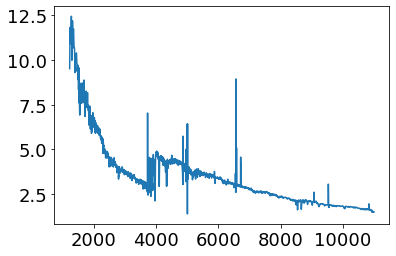

In [14]:
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

tflux = templates[fulltype].flux.T.dot(coeff)
twave = templates[fulltype].wave

plt.plot(twave, tflux)

352.42640310525894 0


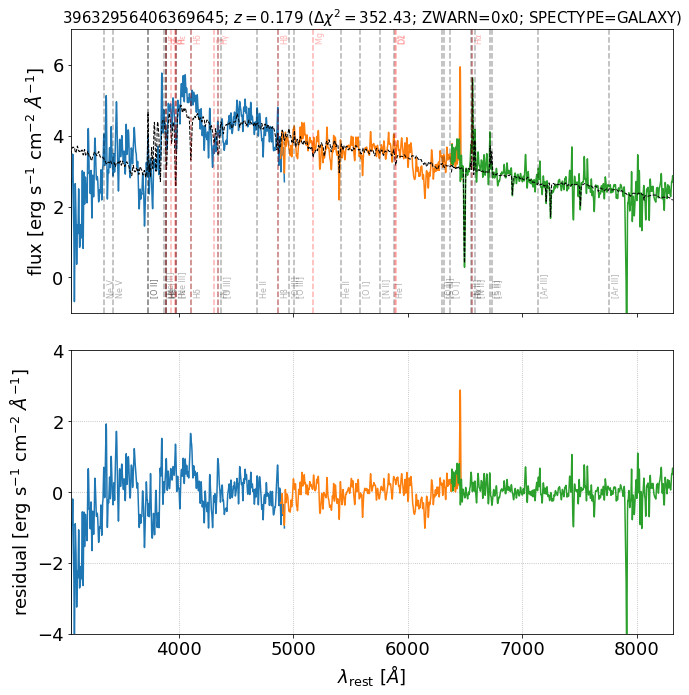

In [15]:
for i in range(myspec.num_spectra()):
    
    fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True, tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    zbest = myspec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)
    
    sptype = zbest['SPECTYPE']
    sbtype = zbest['SUBTYPE']
    fulltype = (sptype, sbtype)
    ncoeff = templates[fulltype].flux.shape[0]
    coeff = zbest['COEFF'][0:ncoeff]
    
    tflux = templates[fulltype].flux.T.dot(coeff)
    twave = templates[fulltype].wave*(1+z)
    
    fmin, fmax = 1e99, -1e99
    for band in 'brz':
        smoothed = gaussian_filter1d(myspec.flux[band][i], 5)
        fmin = np.minimum(fmin, np.min(smoothed))
        fmax = np.maximum(fmax, np.max(smoothed))
        ax.plot(myspec.wave[band]/(1 + z), smoothed)
        
        R = Resolution(myspec.resolution_data[band][i])
        txflux = R.dot(resample_flux(myspec.wave[band], twave, tflux))
        smoothed = gaussian_filter1d(txflux, 5)
        ax.plot(myspec.wave[band]/(1+z), smoothed, color='k', lw=1, ls='--')
        
        residual = myspec.flux[band][i] - txflux
        smoothed = gaussian_filter1d(residual, 5)
        axes[1].plot(myspec.wave[band]/(1+z), smoothed)
    fmax = 7.
    
    for eline in emi_lines:
        wl = eline['lambda']
        if wl > 3600/(1+z) and wl < 9800/(1+z):
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, -0.5, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']
        if wl > 3600/(1+z) and wl < 9800/(1+z):
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(#xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(3600/(1 + z),9800/(1 + z)),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(-1, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(myspec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype),
          )
    
    ax = axes[1]
    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           ylabel=r'residual [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(-4,4))
    ax.grid(ls=':')
    fig.savefig('spec_residual_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']), dpi=120)
#     fig.savefig('spec_nocutout_{}_{}_{:06d}_{:06d}.pdf'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    
#     # Clean up
#     fig.clear()
#     plt.close(fig)